In [1]:
import numpy as np
import math
def GenerateTimeout(Set_Coordinate, robot_pos):
    X_Robot , Y_Robot, A_Robot = robot_pos[0] , robot_pos[1] , robot_pos[2]
    for i in range(len(Set_Coordinate)): 
        time_out_com = math.sqrt( np.float_power(Set_Coordinate[i,0]-X_Robot , 2) + np.float_power(Set_Coordinate[i,1]-Y_Robot , 2) ) / Set_Coordinate[i,2]
        Set_Coordinate[i,3] = time_out_com*1400 + 1500# 140 %(For incertenties +500 ms(For initial acceleration)
        X_Robot = Set_Coordinate[i,0]
        Y_Robot = Set_Coordinate[i,1]
    return Set_Coordinate

def BuildMessage(Set_Coordinate):
    X_Des=Set_Coordinate[j][0]
    Y_Des=Set_Coordinate[j][1]
    Max_Speed=Set_Coordinate[j][2]
    TimeOut=Set_Coordinate[j][3]
    Backward_Parameter=Set_Coordinate[j][4]
    """Create messages"""
    G0_String='G0 X' + str(X_Des)+' Y'+str(Y_Des)+' T'+str(TimeOut)+ ' R'+str(Backward_Parameter)+'\r\n'
    M201_String='M201 H0 S' + str(Max_Speed)+'\r\n'
    M3_String='M3 H3\r\n'
    All_Commands=[G0_String,M201_String,M3_String]
    return All_CommandsBuildMessage(Set_Coordinate)

def SendMessage(All_Commands):
    for i in range(0,len(All_Commands)):
            pass
            buf_stm.append(All_Commands[i])#Send every messages
            
def InitializeSetCoordinate(Coordinate):
    
    Coordinate = np.array(Coordinate)
    
    Set_Coordinate=np.zeros((len(Coordinate),5))
    Set_Coordinate[:,0]=Coordinate[:,0]
    Set_Coordinate[:,1]=Coordinate[:,1]
    Set_Coordinate[:,2]=500;
    Set_Coordinate[:,3]=8000;
    Set_Coordinate[:,4]=Coordinate[:,2];

    
    return Set_Coordinate

def Create_Checkpoint(Space_Around, Robot_Pos,Objectif):
    X_Robot, Y_Robot, A_Robot= Robot_Pos
    X,Y,A=robot.get_position()
    X_Des=Objectif[0]
    Y_Des=Objectif[1]
    New_Coord = []
    Error_X=X_Des-X;
    Error_Y=Y_Des-Y;
    Angle_Des=math.atan2(Error_Y,Error_X)
    Error_Angle = Angle_Des - A
    Angle_Des_Degrees=math.degrees(Angle_Des)
    print(Space_Around)

    if(not(Space_Around['Front']) and Space_Around['Right']):
        X_New=X+math.cos(math.radians(A-90))*300
        Y_New=Y+math.sin(math.radians(A-90))*300
        print('Avoidance Front go to the right',A,X_New, Y_New)
        New_Coord.append([X_New,Y_New,0])

    elif(not(Space_Around['Front']) and Space_Around['Left']): 
        X_New=X+math.cos(math.radians(A+90))*300
        Y_New=Y+math.sin(math.radians(A+90))*300
        print('Avoidance Front go to the Left',X_New, Y_New)
        New_Coord.append([X_New,Y_New,0])
    elif((Space_Around['Front']) and( not(Space_Around['Right'])or not(Space_Around['Left']))):
        
        X_New=X+math.cos(math.radians(A))*300
        Y_New=Y+math.sin(math.radians(A))*300
        New_Coord.append([X_New,Y_New,0])
        print('Avoidance Side go to the Front',X_New, Y_New)
        
    elif(not(Space_Around['Front']) and not(Space_Around['Left']) and not(Space_Around['Right']) ):
    
    
        #Back LEFT
        X_New=X+math.cos(math.radians(A+135))*450
        Y_New=Y+math.sin(math.radians(A+135))*450
        #Back Right
        X_New2=X+math.cos(math.radians(A-135))*450
        Y_New2=Y+math.sin(math.radians(A-135))*450
        if(Is_Position_Free([X_New,Y_New],20)):
            New_Coord.append([X_New,Y_New,0])
            print('Avoidance Front Left Right Go to the Back Left',X_New, Y_New)
        elif(Is_Position_Free([X_New2,Y_New2],20)):
            New_Coord.append([X_New2,Y_New2,0])
            print('Avoidance Front Left Right Go  to the Back Right',X_New2, Y_New2)
        else:
            #Back
            X_New=X+math.cos(math.radians(A+180))*300
            Y_New=Y+math.sin(math.radians(A+180))*300
            New_Coord.append([X_New,Y_New,1])
            print('Avoidance Front Left Right Go*to the Back',X_New, Y_New)
         
         
    else:
        X_New=X
        Y_New=Y
        New_Coord.append([X_New,Y_New,0])
        print('Nothing',X_New, Y_New)
    return New_Coord

In [26]:
set_c0 = InitializeSetCoordinate([[200,200,0]])
set_c1  = InitializeSetCoordinate([[100,100,0],[100,150]])
Set_Coordinate=np.insert(set_c0,0,set_c1,axis=0)
Set_Coordinate



array([[ 100.,  100.,  500., 8000.],
       [ 100.,  150.,  500., 8000.],
       [ 200.,  200.,  500., 8000.]])

In [21]:

##Server
import  time, sys , serial
import threading
import pprint
import time
from Serial_ import *
SERIAL_PORT_ROBOT = '/dev/ttyACM0'
SERIAL_PORT_COllECTOR = '/dev/ttyACM1'
SERIAL_RATE = 115200
import threading
from collections import deque
import TCP_IP as Tcp_Ip
clientCount = 0


buf_broadcast = deque([]) # Queue of message for broadcasting via TCP IP
buf_stm = deque([])

buf_stm

if __name__ == '__main__':
    BUFFER_SIZE = 1024
    ser = serial.Serial(SERIAL_PORT_ROBOT, SERIAL_RATE) # Connection to STM32 ROBOT
    
    serial_T = serialTread(ser)
    
    threading.Thread(target=serial_T.run, args=(buf_broadcast,buf_stm)).start()#create serial thread for robot control
    #conn, addr = Tcp_Ip.enable_tcp_com(BUFFER_SIZE)
    time.sleep(1)

#Changer les action_In et action_Out en queue de dictionaire

SerialException: could not open port '/dev/ttyACM0': FileNotFoundError(2, 'Le chemin d’accès spécifié est introuvable.', None, 3)

In [13]:
import numpy as np
import math
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import matplotlib.pyplot as plt
from parse import *
import  time
%matplotlib inline


def goto_objective(Set_Objective,robot,mapper):
    Robot_is_blocked=False;
    Offset_Timeout=1500;#Raspberry timeout for lack of communication 
    Max_Try=2;#Number of try to send that message
    Try =0
    index_coordinate=0;
    """Concatenate Displacement Movement"""
    Set_Coordinate = InitializeSetCoordinate(Set_Objective)
    
    """ Loop one objective (set of checkpoint) """
    while(not(robot.Has_reached_final_position(Set_Objective)) and index_coordinate< len(Set_Coordinate)):
        """Loop because : 
            - Checkpoint has been reached
            - robot is blocked (Obstacle)
            - robot timeout on the last coordinate, so it will try again to go there.
            - STM32 do not answer (If the break has been removed at the end of the function)
        """
        grid = mapper.map()#Get the actual Map
        X_Robot , Y_Robot, A_Robot  = robot.get_position()
        
        """Check if robot is blocked
        blocked -> see arround and add checkpoint to unblock to robot"""
        
        if(Robot_is_blocked):
            Map_Space = Path_Generator.get_obstacle_robot(robot.get_position(),grid)
            Free_Space=robot.Free_Space_Around(None,robot.get_sensor_state(),Map_Space )
            New_Coord=Create_Checkpoint(Free_Space,(X_Robot , Y_Robot, A_Robot),[Set_Objective[0][0],Set_Objective[0][1]])
            Set_Coordinate_temp = InitializeSetCoordinate(New_Coord)
            Set_Coordinate=np.insert(Set_Coordinate,0,Set_Coordinate_temp,axis=0)
        Robot_is_blocked=False
        """Calculate Optimal Timeout """
        Set_Coordinate = GenerateTimeout(Set_Coordinate, robot.get_position())
        """End """
        print(Set_Coordinate)
        
        """Beginning of the loop for each coordinate the robot has to go through"""
        buf_broadcast.clear()#CLear receiving buffer

        """Build Message to stm from checkpoint in set_coordinate"""
        All_Commands = BuildMessage(Set_Coordinate)
        Finished_Command=0
        Saved_Time=time.time()
        """Send Command to stm"""
        SendMessage(All_Commands)
        """Loop one checkpoint"""
        while(Finished_Command==0 and ((time.time()-Saved_Time)<(Set_Coordinate[index_coordinate][3]+Offset_Timeout)/1000)) :
            #No "M0" message from the STM32 and still on time according to the Raspi
            if(buf_broadcast):
                received=buf_broadcast.popleft()
                print(received)
                str2=parse("M{} X{} Y{} A{} T{} S{}",received)
                if(str2 is not None):
                    array_argument=np.zeros(6)
                    for i in range(0,6):
                        array_argument[i]=float(str2[i])
                    if (array_argument[0]==0):
                        #New robot position is updated in robot object
                        robot.set_position(array_argument[1],array_argument[2],array_argument[3])
                        if array_argument[4]==0: #T0 argument Arrived or sensor
                            Finished_Command=1#M0 has been received, do the next command
                            index_coordinate=index_coordinate+1
                            print('Finished')
                        elif array_argument[4]==1:
                            Finished_Command=1
                            index_coordinate=index_coordinate+1
                            print('Timeout') #Change ?
                        elif array_argument[4]==2:
                            Finished_Command=1
                            Robot_is_blocked=True
                            print('Obstacle')
                        feedback_sensors = int(array_argument[5])# feedback sensor MLKJIHGFEDCBA 
                        mapper.new_obstacle(robot.set_sensor_state(feedback_sensors))
                    else:
                        print('Not M0 Frame',array_argument[0])
                else:#Not an M0 frame 
                    pass
        if(Finished_Command==0 and Try<Max_Try):
            print('Lack of answer from STM32, Try Number '+str(Try+1))
            Try=Try+1
        elif(Try>=Max_Try):
            break #Leave the loop, should it ?
        else:
            Try =0
        """End of try for one coordinate"""

    print('End of total movement')
    

            
    return  Set_Coordinate


In [10]:
print('Position Set')
robot = Robot.robot(250,250,0)

print('Robot objet Set')
mapper = Map_Generator.Mapping()

print('Map objet Set')
Set_Objective=[[2000,250],[250,250]]
print('Main_Loop')

for e in Set_Objective:
    path_,G_ ,checkpoint_ =Main_Loop(e,robot,mapper)
mapper.display(G_,path_,robot,checkpoint_)


print('Requesting Bottle coordinate')
    #list_bottle_coordinate = Tcp_Ip.check_data_received(conn, BUFFER_SIZE)
    #print("New bottle coordinate: ",list_bottle_coordinate)
    #if list_bottle_coordinate != None:
    #    mapper.new_bottle(list_bottle_coordinate)

Position Set
Robot objet Set
Map objet Set
Main_Loop


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
Map_Rewards is a map of rewards(aka bottle or special zone according to the time of the game)
Map_terrain is a map of obstacle and wall 

while(running)
    if(Robot_has_reached_final_position):
        Get_Interresting_Position_To_Go();
    Set_Of_Coordinate=Calculate_Path(Actual_Pos,Position_To_Go,Map_terrain)
    for i in Set_Of_Coordinate
    #From here 
        Send set_of_Coordinate[i]
        Wait_for_answer
        Get_Position of the robot and state
        Actual_Pos=Correlation(Beacon,Robot_Pos)
        if State==Blocked
            Add_To_Map(Actual_Pos,Sensor_Trigged)
            break for loop
        else if State== Finished_Action
            continue
    #to here the robot can move
    Bottle_detection_behavior(Actual_Pos,Map_Rewards)

# Simulation and Test HERE

{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': 0, 'g': 0, 'h': 0, 'i': 0, 'j': 0, 'k': 0, 'l': 0, 'm': 1}
[[3000. 1500.  500. 8000.    0.]]
{'Front': 255, 'FrontLeft': 0, 'Left': 0, 'BackLeft': 0, 'Back': 0, 'BackRigth': 0, 'Right': 0, 'FrontRight': 0}
{'Front': 0, 'Left': 1, 'Right': 1, 'Back': 1, 'FrontLeft': 1, 'FrontRight': 1, 'BackLeft': 1, 'BackRight': 1}
Avoidance Front go to the right 0.0 1500.0 1200.0
[[1500. 1200.  500. 8000.    0.]
 [3000. 1500.  500. 8000.    0.]]


'\nprint("object",objective)\nprint("grid_value",grid_updated[round(objective[1]/10),round(objective[0]/10)])\nvalid_objective = Path_Generator.validate_objective(objective,grid_updated, robot.get_position())\ntheta_robot = robot.get_position()[2]\n#x_start = robot.get_position()[0] + 330*math.cos(theta_robot)\n#y_start = robot.get_position()[1] + 330*math.sin(theta_robot)\nprint(Path_Generator.get_obstacle_robot(robot.get_position(),grid_updated))\n#path, cost , G = Path_Generator.AStarSearch((x_start,y_start), (valid_objective[0],valid_objective[1]), grid_updated)#Try to find the best path\n#checkpoint = Path_Generator.find_vertice(path)#Simplify the path to be straight line\n#checkpoint = Path_Generator.checkpoint_corrector(checkpoint)\n#new_x,newy,theta_robot = Path_Generator.checkpoint_in_fov(robot,checkpoint)\n\n\n'

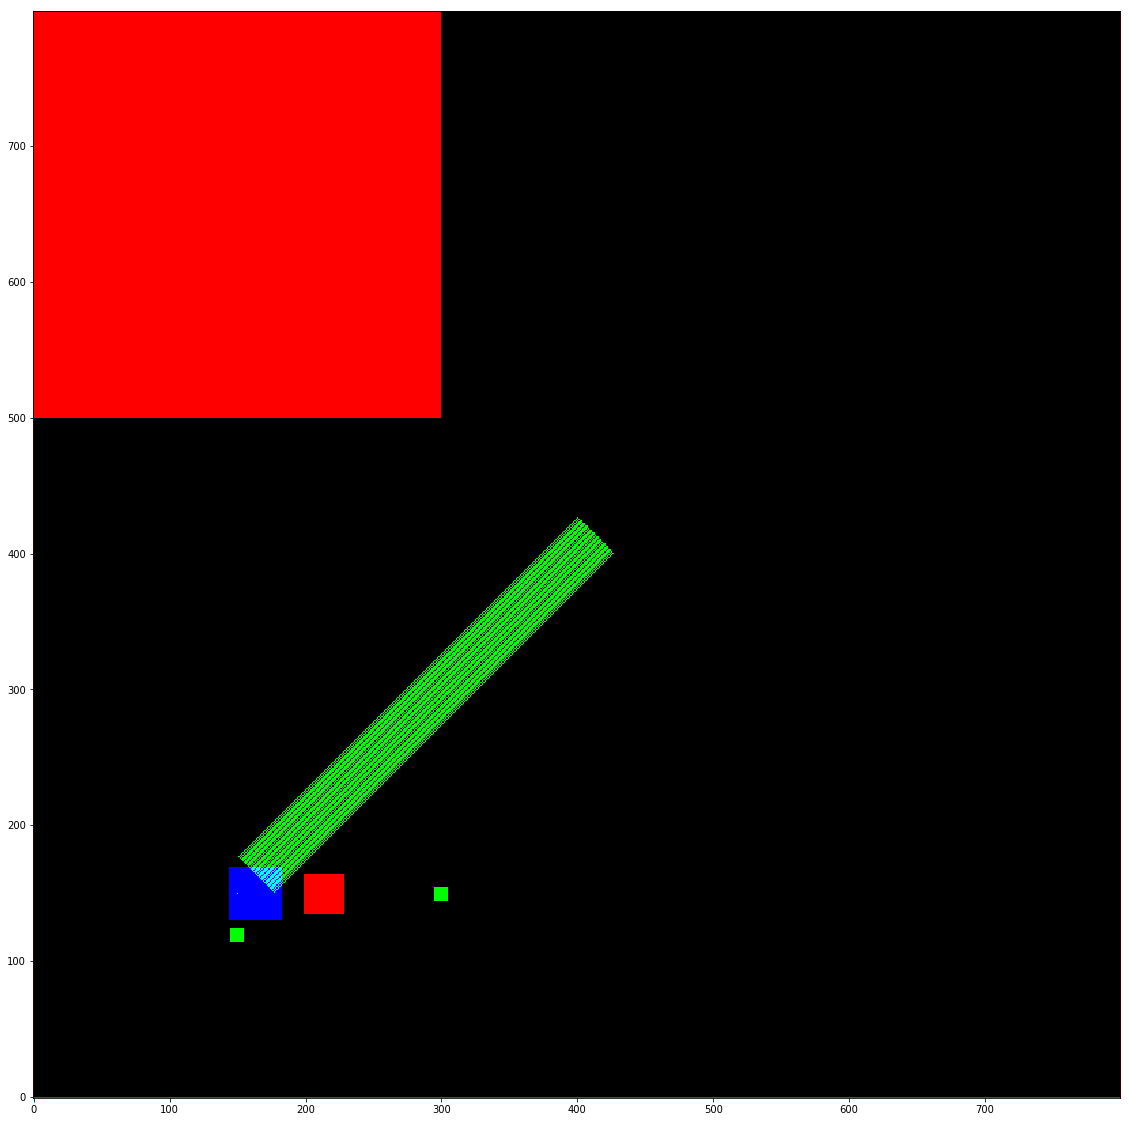

In [2]:
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import numpy as np
import matplotlib.pyplot as plt
from parse import *
import math
%matplotlib inline

robot = Robot.robot(1500,1500,0)

#print(robot.get_beacon_position())
#print(robot.set_sensor_state(2048+16))
mapper = Map_Generator.Mapping()
grid_updated=mapper.map()

#XY = robot.set_sensor_state(1+2+4096)

#mapper.new_obstacle([[300,160]])
grid_updated=mapper.map()
Set_Objective = [[3000,1500,0]]
mapper.new_obstacle(robot.set_sensor_state(4096))
grid=mapper.map()
#list_bottle_coordinate = Tcp_Ip.check_data_received(conn, BUFFER_SIZE)
#if list_bottle_coordinate != None:
#    mapper.new_bottle(list_bottle_coordinate)
X_Robot, Y_Robot, A_Robot = robot.get_position()
Path_Generator.get_map_information(robot.get_position(),grid,45 ,5000 )
Path_Generator.get_obstacle_robot(robot.get_position(),grid)
#


Set_Coordinate = InitializeSetCoordinate(Set_Objective)
print(Set_Coordinate)
Map_Space = Path_Generator.get_obstacle_robot(robot.get_position(),grid)
Free_Space=robot.Free_Space_Around(robot.get_sensor_state(),Map_Space )
New_Coord=Create_Checkpoint(Free_Space,(X_Robot , Y_Robot, A_Robot),[Set_Objective[0][0],Set_Objective[0][1]])
Set_Coordinate_temp = InitializeSetCoordinate(New_Coord)
Set_Coordinate=np.insert(Set_Coordinate,0,Set_Coordinate_temp,axis=0)
print(Set_Coordinate)
path = Path_Generator.get_path(grid,[4000,4000],robot.get_position())
mapper.display(path,robot,Set_Coordinate)
"""
print("object",objective)
print("grid_value",grid_updated[round(objective[1]/10),round(objective[0]/10)])
valid_objective = Path_Generator.validate_objective(objective,grid_updated, robot.get_position())
theta_robot = robot.get_position()[2]
#x_start = robot.get_position()[0] + 330*math.cos(theta_robot)
#y_start = robot.get_position()[1] + 330*math.sin(theta_robot)
print(Path_Generator.get_obstacle_robot(robot.get_position(),grid_updated))
#path, cost , G = Path_Generator.AStarSearch((x_start,y_start), (valid_objective[0],valid_objective[1]), grid_updated)#Try to find the best path
#checkpoint = Path_Generator.find_vertice(path)#Simplify the path to be straight line
#checkpoint = Path_Generator.checkpoint_corrector(checkpoint)
#new_x,newy,theta_robot = Path_Generator.checkpoint_in_fov(robot,checkpoint)


"""


[1500. 1200.  500. 8000.    0.]
[3000. 1500.  500. 8000.    0.]


# Old Main loop (Astar :)

import numpy as np
import math
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator

import matplotlib.pyplot as plt
from parse import *
%matplotlib inline
def Main_Loop(Set_Objective,robot,mapper):
    checkpoint_ = []
    path=None
    G=None
    Stopedby_Obstacle= 0
    checkpoint_Init= None
    while(not(robot.Has_reached_final_position(Set_Objective))):
        #print(Tcp_Ip.check_data_received(conn, BUFFER_SIZE))
        print('Get_Map')
        grid = mapper.map()#Get the actual Map
        Get_Pos=robot.get_position()# Get the actual robot Position
        
            
        
        
        if( Stopedby_Obstacle >=2):
            theta_robot = robot.get_position()[2]
            x_start = robot.get_position()[0]
            y_start = robot.get_position()[1]
            #checkpoint_Init=[robot.get_position()[0]- 330*math.cos(theta_robot),robot.get_position()[1]- 330*math.sin(theta_robot)]
            Stopedby_Obstacle=0
            checkpoint = np.array([[x_start,y_start]])
            print('Blocked, Move Back to : ',x_start,y_start)
        else:    
            theta_robot = robot.get_position()[2]
            x_start = robot.get_position()[0] + 330*math.cos(theta_robot)
            y_start = robot.get_position()[1] + 330*math.sin(theta_robot)
            print("verify objective")
            verified_Obj = Path_Generator.validate_objective(Set_Objective,grid, [x_start,y_start])
            print('Astar Beginning')
            path, cost , G = Path_Generator.AStarSearch([x_start,y_start], (verified_Obj[0],verified_Obj[1]), grid) #Try to find the best path
            checkpoint = Path_Generator.find_vertice(path)#Simplify the path to be straight line
            print('Astar End')
        #if checkpoint_Init != None:
        #    checkpoint=np.insert(checkpoint,0,checkpoint_Init)
        #checkpoint = Path_Generator.checkpoint_corrector(checkpoint)
        #new_x,newy,theta_robot = Path_Generator.checkpoint_in_fov(robot,checkpoint)#Try to avoid backward movement unless it is too far back
        #checkpoint = Path_Generator.checkpoint_corrector(checkpoint)#Eliminate again some short path line 
        #print("OLD CHECKPOINT", checkpoint)
        #checkpoint = np.insert(checkpoint,0,[new_x,newy]).reshape((-1,2))# Add repositionning for avoiding backward movement
        #print("NEW CHECKPOINT", checkpoint)
        

        """Concatenate Displacement Movement"""
        Set_Coordinate=np.zeros((len(checkpoint),4))
        Set_Coordinate[:,0]=checkpoint[:,0]
        Set_Coordinate[:,1]=checkpoint[:,1]
        Set_Coordinate[:,2]=500;
        Set_Coordinate[:,3]=8000;
        """Calculate Optimal Timeout"""
        tempX , tempY, _  = robot.get_position()
        for i in range(len(Set_Coordinate)): 
            time_out_com = math.sqrt( np.float_power(Set_Coordinate[i,0]-tempX , 2) + np.float_power(Set_Coordinate[i,1]-tempY , 2) ) / Set_Coordinate[i,2]
            Set_Coordinate[i,3] = time_out_com*1400 + 1500# 140 %(For incertenties +500 ms(For initial acceleration)
            tempX = Set_Coordinate[i,0]
            tempY = Set_Coordinate[i,1]
        print(Set_Coordinate)
        """Beginning of the loop for each coordinate the robot has to go through"""

        buf_broadcast.clear()#CLear receiving buffer
        Offset_Timeout=1500;#Raspberry timeout for lack of communication 
        Max_Try=2;#Number of try to send that message
        Try =0
        j=0
        while j <len(Set_Coordinate) :
            print(j)
            """Get information of one movement"""
            X_Des=Set_Coordinate[j][0]
            Y_Des=Set_Coordinate[j][1]
            Max_Speed=Set_Coordinate[j][2]
            TimeOut=Set_Coordinate[j][3]
            """Create messages"""
            G0_String='G0 X' + str(X_Des)+' Y'+str(Y_Des)+' T'+str(TimeOut)+'\r\n'
            M201_String='M201 H0 S' + str(Max_Speed)+'\r\n'
            M3_String='M3 H3\r\n'
            All_Commands=[G0_String,M201_String,M3_String]
            Finished_Command=0
            Saved_Time=time.time()
            for i in range(0,len(All_Commands)):
                buf_stm.append(All_Commands[i])#Send every messages
            while(Finished_Command==0 and ((time.time()-Saved_Time)<(Set_Coordinate[j][3]+Offset_Timeout)/1000)) :
                #No "M0" message from the STM32 and still on time according to the Raspi
                if(buf_broadcast):
                    received=buf_broadcast.popleft()
                    print(received)
                    str2=parse("M{} X{} Y{} A{} T{} S{}",received)
                    if(str2 is not None):
                        array_argument=np.zeros(6)
                        for i in range(0,6):
                            array_argument[i]=float(str2[i])
                        if (array_argument[0]==0):
                            robot.set_position(array_argument[1],array_argument[2],array_argument[3])
                            if array_argument[4]==0: #T0 argument Arrived or sensor
                                Finished_Command=1#M0 has been received, do the next command
                                print('Finished')
                                Stopedby_Obstacle= 0
                            elif array_argument[4]==1:
                                Finished_Command=1
                                
                                Stopedby_Obstacle= 0
                                print('Timeout')
                            elif array_argument[4]==2:
                                Finished_Command=1
                                
                                Stopedby_Obstacle+=1
                                
                                print('Obstacle')
                            feedback_sensors = int(array_argument[5])# feedback sensor MLKJIHGFEDCBA 
                            mapper.new_obstacle(robot.sensor_state(feedback_sensors))
                        else:
                            print('Not M0 Frame',array_argument[0])
                    else:#Not an M0 frame 
                        pass
            if(Finished_Command==0 and Try<Max_Try):
                print('Lack of answer from STM32, Try Number '+str(Try+1))
                Try=Try+1
            else:
                j=j+1
                Try =0
            """End of try for one coordinate"""

        print('End of total movement')
        print('Requesting Bottle coordinate')
        #list_bottle_coordinate = Tcp_Ip.check_data_received(conn, BUFFER_SIZE)
        #print("New bottle coordinate: ",list_bottle_coordinate)
        #if list_bottle_coordinate != None:
        #    mapper.new_bottle(list_bottle_coordinate)
            
            
    return path, G , checkpoint
print('Main')